In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique #, unionize
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_indices_2ormore

# from mcmodels.core.utils import get_regionalized_normalized_data
# from mcmodels.core.utils import get_connectivity
# from mcmodels.core.utils import get_ontological_order_leaf
# from mcmodels.core.utils import get_nw_loocv,get_wt_inds
# from mcmodels.core.utils import get_countvec
# from mcmodels.core.utils import get_injection_hemisphere_id
# from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
# from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation

In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False)

connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs

512
703
1089
1097
315
313
354
698
771
803
477
549


In [4]:
class Crossval:
    
    def __init__(self):
        2+2
        

In [5]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
#experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)
#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)

#contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
#ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
#source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order_leaves)[np.isin(ontological_order_leaves, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

In [6]:
connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

In [7]:
nw_leaf_creleaf2 = Crossval()

gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])
#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.leaf2_index_matrices[sid], 
                                                                                       connectivity_data.leaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])

a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))


#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


AttributeError: 'ConnectivityData' object has no attribute 'creleaf2_evalindices'

In [8]:
connectivity_data.creleaf2_evalindices = get_eval_indices(connectivity_data.creleaf2_index_matrices)


In [9]:
nw_leaf_creleaf2.loocvpredictions = loocvpredictions
nw_leaf_creleaf2.losses = get_loss(reg_proj_norm, nw_leaf_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
nw_leaf_creleaf2.bestgamma  = get_best_hyperparameters(nw_leaf_creleaf2.losses,keys)
nw_leaf_creleaf2.meanloss = get_loss_best_hyp(nw_leaf_creleaf2.losses, nw_leaf_creleaf2.bestgamma)


In [10]:
nw_leaf_creleaf2.meanloss,nw_leaf_creleaf2.bestgamma

(array([0.03932715, 0.60140432, 0.12768485, 0.24344176, 0.27679931,
        0.19352544, 0.196393  , 0.05569082, 0.34631698, 0.23927236,
        0.08091236, 0.30957263]), array([[1],
        [0],
        [1],
        [2],
        [2],
        [3],
        [2],
        [0],
        [3],
        [2],
        [2],
        [1]]))

In [12]:
def get_connectivity_matrices2_nw(connectivity_data, gamma_dict, cres, structures, model_ordering, source_ordering, target_ordering, eval_cres, cre_model = True):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(eval_cres)

    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = model_ordering[i,0]#structure_major_dictionary[source_ordering[i]]
            gamma = gamma_dict[sid]
            connectivity[c,i] = get_region_prediction2(cache,
                                                      connectivity_data.structure_datas[sid],
                                                      exp_structures = structures[sid],
                                                      model_region = model_ordering[i,1],
                                                      prediction_region= source_ordering[i],
                                                      cre = eval_cres[c],
                                                      gamma = gamma_dict[sid],
                                                      cre_model = cre_model)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)

In [17]:
gd_nw_crestr_creleaf2 = {}
gd_nw_creleaf_creleaf2 = {}
gd_nw_str_creleaf2 = {}
gd_nw_leaf_creleaf2 = {}

for m in range(12):
    sid = major_structure_ids[m]
    #gd_nw_crestr_creleaf2[sid] = gammas[nw_crestr_creleaf2.bestgamma[m]]
    #gd_nw_creleaf_creleaf2[sid] = gammas[nw_creleaf_creleaf2.bestgamma[m]]
    #gd_nw_str_creleaf2[sid] = gammas[nw_str_creleaf2.bestgamma[m]]
    gd_nw_leaf_creleaf2[sid] = gammas[nw_leaf_creleaf2.bestgamma[m]]

In [46]:
gd_nw_leaf_creleaf2

{512: array([0.01]),
 703: array([0.001]),
 1089: array([0.01]),
 1097: array([0.1]),
 315: array([0.1]),
 313: array([1.]),
 354: array([0.1]),
 698: array([0.001]),
 771: array([1.]),
 803: array([0.1]),
 477: array([0.1]),
 549: array([0.01])}

In [21]:
crelist = ['C57BL/6J']
eval_cres = ['C57BL/6J']

In [25]:
# #prediction_region needs to be changed to include only leafs with summary structure experiments present...
# #inherits from source_orders

# #methods needs to be altered to allow for predictions outside region

# from mcmodels.core import Mask

# def get_connectivity_matrices(connectivity_data, cres, structure_dict, source_ordering, model_ordering, target_ordering, structure_major_dictionary,gamma_dict = None):
    
#     nsource = len(source_ordering)
#     #n#target = len(target_ordering)
#     ncre = len(cres)
    
#     ipsi_target_regions = connectivity_data.ipsi_target_regions
#     contra_target_regions = connectivity_data.contra_target_regions     
                                                      
#     ipsi_indices= np.asarray([])
#     contra_indices = np.asarray([])
#     for iy in target_ordering: 
#         #print(iy)
#         ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
#         contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
#     ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
#     contra_indices = np.asarray(contra_indices, dtype = int)   
    
#     #reorder = np.concatenate([ipsi_indices, contra_indices])  
#     reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    
#     ntarget = len(reorder)
      
#     connectivity = np.zeros((ncre, nsource, ntarget))
#     connectivity[:] = np.nan
#     #structure_major_dictionary = connectivity_data.structure_major_dictionary
#     for c in range(ncre):
#         for i in range(nsource):
#             print(i,source_ordering[i])
#             sid = structure_major_dictionary[source_ordering[i]]
#             gamma = gamma_dict[sid]
#             connectivity[c,i] = get_region_prediction(cache, connectivity_data.structure_datas[sid], structures = structure_dict[sid], model_region = model_ordering[i], prediction_region=source_ordering[i], cre = cres[c], gamma = gamma, surface = connectivity_data.structure_datas[sid].loss_surface_cv, cre_model = True)
                                                      
#     connectivity = connectivity[:,:,reorder]                                                  
                                                      
#     return(connectivity)

# def get_region_prediction(cache, structure_data,  structures, model_region, prediction_region, cre, gamma, surface = None, cre_model = False):
    
#     leaf_experiments = np.where(structures == model_region)[0]
#     nexp = len(leaf_experiments)
#     centroids = structure_data.centroids[leaf_experiments]
#     cres = structure_data.crelines[leaf_experiments]
#     projections = structure_data.reg_proj_norm[leaf_experiments]
#     mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

#     if surface != None and cre_model != True:
#         means = get_means(projections,cres, np.repeat(model_region,nexp))
        
#         losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
#         predictions = get_nw_predictions(projections, losses, gamma)
#         output = np.mean(predictions, axis = 0)
        
#     if surface != None and cre_model == True:
#         means = get_means(projections, cres, np.repeat(model_region,nexp))
#         #print(means)
#         if np.isin(cre, np.asarray(list(means[model_region].keys()))):
#             losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
#             predictions = get_nw_predictions(projections, losses, gamma)
#             output = np.mean(predictions, axis = 0)
#         else:
#             output = np.zeros(projections.shape[1])
#             output[:] = np.nan
            
#     if surface == None and cre_model != True:
#         means = get_means(projections, cres, [model_region])
#         predictions = means[cres]
#         output = np.mean(predictions, axis = 0)
        
#     if surface == None and cre_model == True:
#         predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
#         output = np.mean(predictions, axis = 0)
    
#     return(output)

#prediction_region needs to be changed to include only leafs with summary structure experiments present...
#inherits from source_orders

#methods needs to be altered to allow for predictions outside region

from mcmodels.core import Mask

def get_connectivity_matrices2(connectivity_data, surfaces, cres, structures, model_ordering, source_ordering, target_ordering, eval_cres):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(eval_cres)

    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = model_ordering[i,0]#structure_major_dictionary[source_ordering[i]]
            gamma = gamma_dict[sid]
            connectivity[c,i] = get_region_prediction2(cache,
                                                      connectivity_data.structure_datas[sid],
                                                      exp_structures = structures[sid],
                                                      model_region = model_ordering[i,1],
                                                      prediction_region= source_ordering[i],
                                                      cre = eval_cres[c],
                                                      gamma = surfaces[sid].bestgamma,
                                                      surface = surfaces[sid],
                                                      cre_model = True)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)

def get_region_prediction2(cache, structure_data,  exp_structures, model_region, prediction_region, cre, gamma, surface = None, cre_model = False):
    
    model_experiments = np.where(exp_structures == model_region)[0]
    nexp = len(model_experiments)
    
    cres = structure_data.crelines[model_experiments]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

#     if surface != None and cre_model != True:
#         means = get_means(projections,cres, np.repeat(model_region,nexp))
        
#         losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
#         predictions = get_nw_predictions(projections, losses, gamma)
#         output = np.mean(predictions, axis = 0)
        
    if surface != None and cre_model == True:
        projections = structure_data.reg_proj_norm[model_experiments]
        centroids = structure_data.centroids[model_experiments]
        means = get_means(projections, cres, np.repeat(model_region,nexp))
        #print(means)
        print(prediction_region, model_region,means.keys())
        #supposed to check if theres a cre in that region
        if np.isin(model_region, list(means.keys())):
            if np.isin(cre, np.asarray(list(means[model_region].keys()))):
                losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
                predictions = get_nw_predictions(projections, losses, gamma)
                output = np.mean(predictions, axis = 0)
            else:
                output = np.zeros(projections.shape[1])
                output[:] = np.nan
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan           
#     if surface == None and cre_model != True:
#         means = get_means(projections, cres, [model_region])
#         predictions = means[cres]
#         output = np.mean(predictions, axis = 0)
        
    if surface == None and cre_model == True:
        
        
        modelcre_experiments = np.where(cres == cre)[0]
        if len(modelcre_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments][modelcre_experiments]
            centroids = structure_data.centroids[model_experiments][modelcre_experiments]
            #print((pairwise_distances(centroids, mask.coordinates)**2).shape)
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
            
    if surface == None and cre_model == False:
        
        if len(model_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments]
            centroids = structure_data.centroids[model_experiments]
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
        
    return(output)


In [27]:

for sid in major_structure_ids:
    connectivity_data.structure_datas[sid].crelines = connectivity_data.creline[sid]

In [29]:

def get_nw_predictions(projections, dists, gamma):
  
     
    projections = np.asarray(projections, dtype=np.float32)
    neval = dists.shape[1]
    #nexp = centroids.shape[0]
    predictions = np.zeros((neval, projections.shape[1]))
    predictions[:] = np.nan
    
    #print(model_index_val.shape, eval_index_val.shape)
    #weights = np.exp(- dists / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
    for i in range(neval):
        dists_i = dists[:,i] - np.min(dists[:,i])
        #dists_i = dists[i,:] - np.min(dists[i,:])
        weights_i = np.exp(- dists_i * gamma)
        weights_i = np.asarray(weights_i, dtype=np.float32)
        weights_i[np.isnan(weights_i)] = 0.
        weights_i = weights_i / np.sum(weights_i)
        predictions[i] = np.dot(weights_i, projections)
        
    return(predictions) 

    

In [33]:
target_ordering= ontological_order_leaves
rnames = np.asarray([ia_map[ontological_order_leaves[i]] for i in range(len(ontological_order_leaves))])
ipsi_target_regions = connectivity_data.ipsi_target_regions
contra_target_regions = connectivity_data.contra_target_regions                               
ipsi_indices= np.asarray([])
contra_indices = np.asarray([])
for iy in target_ordering: 
    ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
    contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
contra_indices = np.asarray(contra_indices, dtype = int)    
reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
ntarget = len(reorder)

#cnames = np.concatenate([ipsi_colnames, contra_colnames])

In [34]:
colids = np.concatenate([ipsi_target_regions, contra_target_regions])[reorder]
cnames = np.asarray([ia_map[colids[i]] for i in range(len(colids))])

In [35]:
connectivity_matrices_leafall = get_connectivity_matrices2_nw(connectivity_data,
                                                      gamma_dict = gd_nw_leaf_creleaf2,
                                                   cres = crelist,
                                                  structures = leafs,
                                                  model_ordering = np.asarray([[315,315,315,315,315,315],[593, 821, 721, 778, 33, 305]], dtype = int).transpose(),
                                                  eval_cres = eval_cres,
                                                  source_ordering = ontological_order_leaves[117:123],
                                                  target_ordering= ontological_order_leaves,
                                                     cre_model = False)
connectivity_matrices_leafall = pd.DataFrame(connectivity_matrices_leafall[0], columns = cnames, index=np.asarray(['VISp1','VISp2/3','VISp4','VISp5','VISp6a','VISp6b']))

0 593.0
1 821.0
2 721.0
3 778.0
4 33.0
5 305.0


In [39]:
wt_conn = pd.DataFrame(connectivity_matrices_leafall, index = rnames, columns = cnames)

In [41]:
#np.asarray(wt_conn.columns)
source_regions = np.asarray(['VISp2/3', 'VISp4', 'VISp5', 'VISp6a','VISl4', 'VISl5', 'VISl6a'])
target_regions = np.concatenate([source_regions,['LGd-sh', 'LGd-co', 'LGd-ip']])
#target_regions = np.asarray(['LGv','LGd','VISp','VISl'])

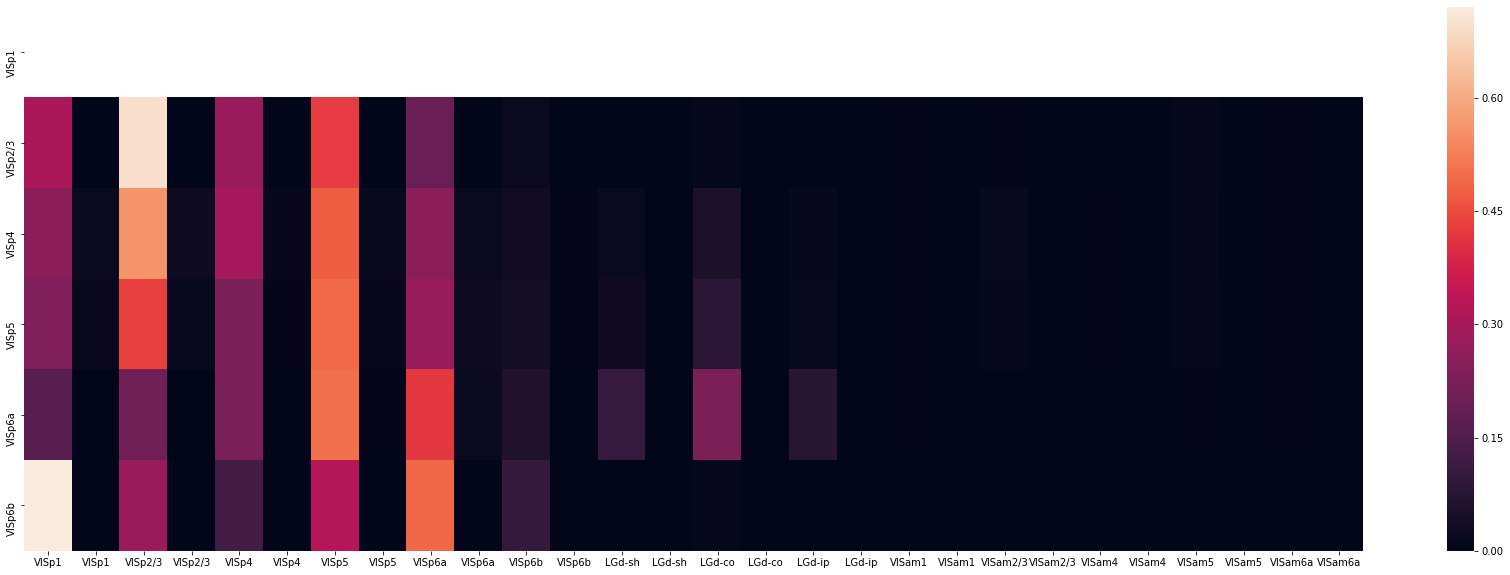

In [44]:
srs = np.asarray(['VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b'])
trs = np.asarray(['VISp1', 'VISp2/3' ,'VISp4', 'VISp5' ,'VISp6a','VISp6b','LGd-sh', 'LGd-co', 'LGd-ip','VISam1','VISam2/3','VISam4','VISam5', 'VISam6a'])

fig, axes = plt.subplots(figsize = (30,10))
sns.heatmap(connectivity_matrices_leafall.loc[srs].loc[:,trs])